# Create functions to run power spectra moments

In [1]:
#set up and fixed power spectra to work with (based on 2019-07-18 Synch maps spatial variation)


#------packages-------------------
%pylab inline

import healpy as hp

#-------constants------------------
TCMB = 2.7255  # Kelvin
hplanck = 6.626070150e-34  # MKS
kboltz = 1.380649e-23  # MKS


#-------functions------------------
#defines the ell power law that we will use for the A_s spectrum
def powerlaw(ell, alpha):
    return (ell/ 80.)**alpha

#defines a normal planck distribution 
def normed_cmb_thermo_units(nu):
    X = hplanck * nu / (kboltz * TCMB)
    eX = np.exp(X)
    return eX * X**4 / (eX - 1.)**2

#define the synchrotron SED.
#define what frequency map we want to look at. Start with 2.3 GHz
nu0 = 2.3e9 

def normed_synch(nu, beta):
    if beta is not np.array:
        beta = np.array(beta)
    return (nu/nu0)**(2.+beta[..., np.newaxis])

def scale_synch(nu, beta):
    unit = normed_synch(nu, beta) * normed_cmb_thermo_units(nu0) / normed_cmb_thermo_units(nu)
    return unit


#-------BB parameters (to start)--------
A_BB = 1.7e3
alpha_BB = -3.0
beta_BB = -3.2

#-------map paramters--------------------
nside = 128
Lmax = 384
ells = np.arange(1,Lmax+1)

Populating the interactive namespace from numpy and matplotlib


In [2]:
"""
----Notation used in this notebook----

ells    - the ells up to ell_max = 384
pcls    - the power law C_ell defined through pcls = (ell/80)^alpha_BB
check_cls - the extracted C_ell from a map using anafast

sbb     - the power law map in ell. This will be used for all complete maps, as we're only modifying the frequency dep.


sed_scaling_<x> - the scaled_synch function on frequencies and some beta. Up to unit conversion this is (nu/nu_0)^beta
                  where beta is either just a constant or is a whole map of betas


newmaps_<x>    - newmaps_<x> = sbb * sed_scaling_<x>. This is a series of 'real' frequency maps

""";

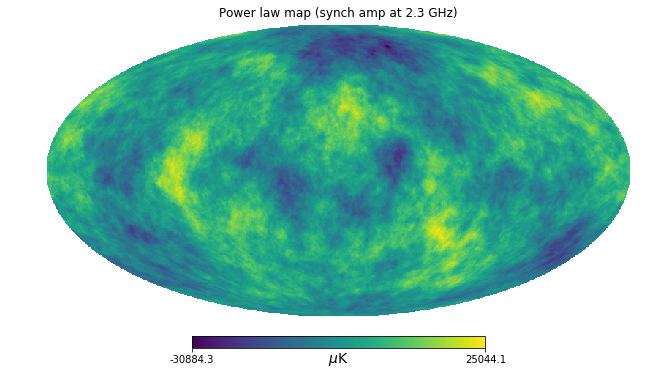

In [3]:
#define C_ell with a power law dependence on ell
#pcls for Power law C_Ls
pcls = A_BB * powerlaw(ells, alpha_BB)
pcls[0] = 0 
pcls[1] = 0

#-----AMPLITUDE MAP----------
sbb = hp.synfast(pcls, nside, new=True, verbose=False)
hp.mollview(sbb, unit=r'$\mu \rm K$', title='Power law map (synch amp at 2.3 GHz)')

#----AMPLITUDE MAP---------------------------
#these are the amplitude cls
check_pcls = hp.anafast(sbb)

In [4]:
#SED maps---constant beta-------

#define list of frequencies going from 10 to 300 GHz, sampling 20 points
freqs = np.linspace(10,300,20)*1.e9

#define the SED scaling
sed_scaling = scale_synch(freqs, beta_BB)

#the maps including SED at different frequencies
newmaps = sbb * sed_scaling[..., np.newaxis]


In [5]:
#varying beta
beta_sigma = 1.5e-6

#define a 'beta map' using uniform C_ell
bcls = beta_sigma * ones_like(ells)  #makes a vector [1.5e-6, ... , 1.5e-6] with the same shape as the ells
beta_map = hp.synfast(bcls, nside, new=True, verbose=False)
#update the map so that the mean is correct
beta_map -= (np.mean(beta_map) + 3.2)


#drawn out beta cls
check_bcls = hp.anafast(beta_map)

#make series of beta maps
sed_scaling_beta = scale_synch(freqs, beta_map).T

#make ''realistic maps'' from sbb*new SED
newmaps_beta = sbb * sed_scaling_beta

In [6]:
'''
Maps made at this stage:

Frequency amplitude maps -- in paper called Sy -- in code called sbb
Beta map -- in paper called beta_s -- in code called beta_map
Realistic maps -- in code called newmaps, newmaps_beta
''';

In paper, equation (35):
$$
C_\ell^{\nu_1\nu_2}(1\times 1) = \partial_{\beta_s}\mathrm{Sy}^{\nu_1}\partial_{\beta_s}\mathrm{Sy}^{\nu_2}\underbrace{\sum_{\ell_1\ell_2}\frac{(2\ell_1+1)(2\ell_2+1)}{4\pi}\begin{pmatrix} \ell & \ell_1 & \ell_2 \\ 0 & 0 & 0 \end{pmatrix}^2 \langle \mathrm{Sy}\mathrm{Sy}\rangle_{\ell_1}\langle \beta_s \beta_s \rangle_{\ell_2}}_{\texttt{wignersum}}
$$

In terms of code parameters
$$
C_\ell^{\nu_1\nu_2}(1\times 1) = \partial_{\beta_s}\mathrm{SED}^{\nu_1}\partial_{\beta_s}\mathrm{SED}^{\nu_2} \sum_{\ell_1\ell_2} \mathrm{normalisation} * (W^{\ell,\ell_1,\ell_2}_{0,0,0})^2 * \texttt{check_pcls[ell_1]} * \texttt{check_bcls[ell_2]}
$$

Now as we model the SED as a power law in $\beta$ we can write:
$$
\partial_\beta \mathrm{SED}(\nu) = \ln\left(\frac{\nu}{\nu_0}\right) \times \mathrm{SED}(\nu)
$$

In [7]:
from pyshtools.utils import Wigner3j

In [8]:
high_ell = 384
extended_ells = np.arange(1, high_ell + 1)
wignersum = np.zeros_like(extended_ells, dtype=float)
wigner_squared = 0

synch_cls = A_BB * powerlaw(extended_ells, alpha_BB)
synch_cls[0] = 0
synch_cls[1] = 0

beta_cls = beta_sigma * ones_like(extended_ells)



In [13]:
import time
start = time.time()

for ell1 in extended_ells[:high_ell-1]:
    for ell2 in extended_ells[:high_ell-1]:
        #-----calculate the wigner coefficients-------
        
        #finds all the non-zero wigner 3j coefficients compatible with the other 5 numbers
        #returns w3j, an array of these 3j coeff, ellmin, the j corresponding to the first non-zero of w3j, 
        #ellmax, the j corresponding to the last non-zero of w3j
        w3j, ellmin, ellmax = Wigner3j(ell1, ell2, 0, 0, 0)
        avaliable_ells = np.arange(ellmin, ellmax+1)

        #this block forces all the w3j arrays to have the same size as the wignersum array
        #cut off trailing zeros at the end of w3j
        max_nonzero_index = ellmax - ellmin 
        w3j = w3j[:max_nonzero_index + 1]
        
        r'''w3j = [w3j[0], w3j[1], ... , w3j[n]] with w3j[n] != 0 at this stage''' 
    
        #make the w3j array the same shape as the wignersum array
        if len(w3j) < len(extended_ells):
            #if the w3j is shorter than the input ells, then pad to the end with zeros
            padding = np.zeros(len(wignersum)-len(w3j))
            w3j = np.append(w3j, padding)
        else:
            w3j=w3j
           
        #roll stuff into position and relabel those that roll ''around'' to 0
        w3j = np.roll(w3j, ellmin)
        w3j[:ellmin] = np.zeros_like(w3j[:ellmin])
        
        r'''w3j = [0, 0, ... , w3j[0-ellmin], w3j[1-ellmin], ...] '''
        
        #cut to size of the moment that we're adding (the size of the ells matrix)
        w3j = w3j[:len(extended_ells)]
        #----------------------------------------
        
        
        #-------maps and normalisation-----------
        #define the normalisation factor in above equation
        factor = (2 * ell1 + 1)*(2 * ell2 + 1)/(4*pi)
        A = synch_cls[ell1]
        B = beta_cls[ell2]
        #------------------------------------------


        #define wignersum to be the array with the sum of the squares of the wigner coefficients
        wigner_squared += w3j**2
        wignersum += w3j**2 * factor * A * B
        
end = time.time()
print('time taken = ' + str(end - start))

time taken = 11.919871091842651


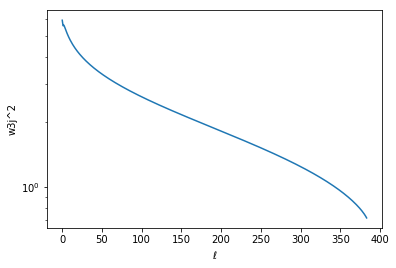

In [14]:
#similarly, want to plot the sum of the w3j^2 over ell1 and ell2 as a function of ell
semilogy(wigner_squared)
xlabel('$\ell$')
ylabel('w3j^2');

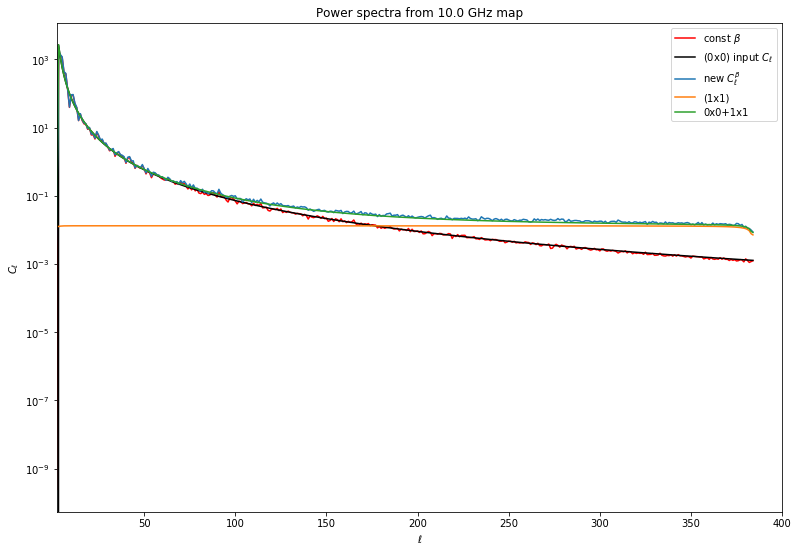

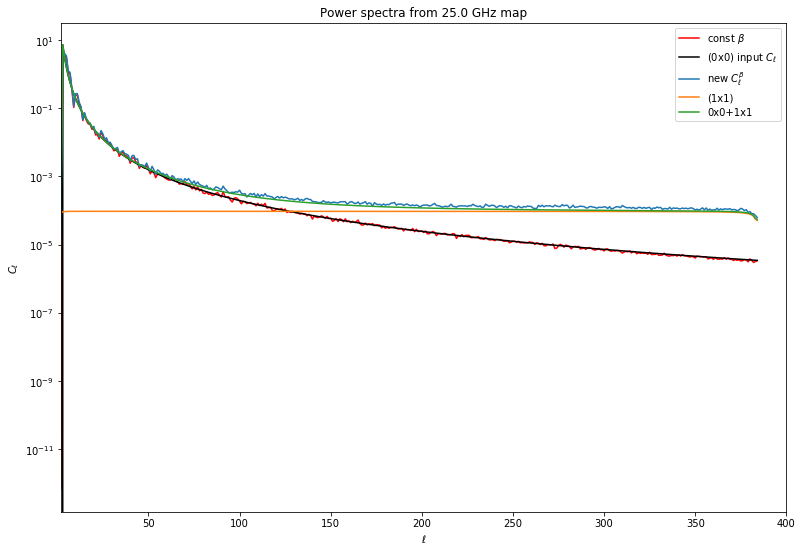

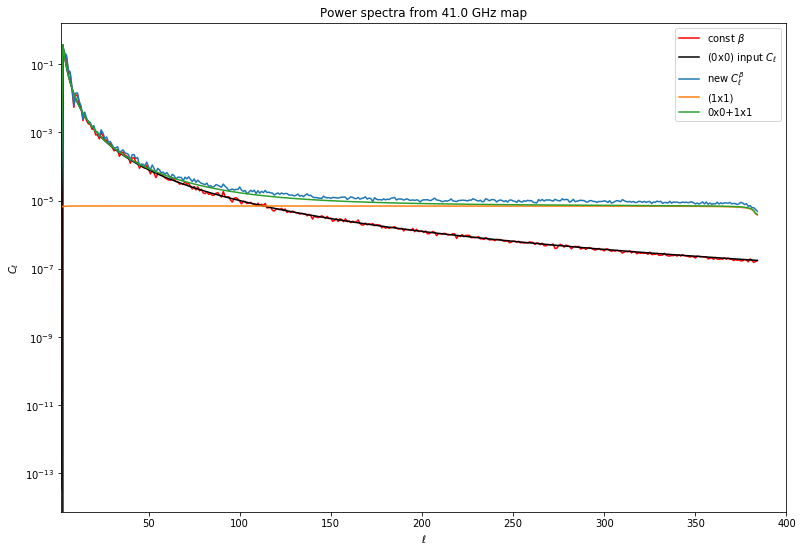

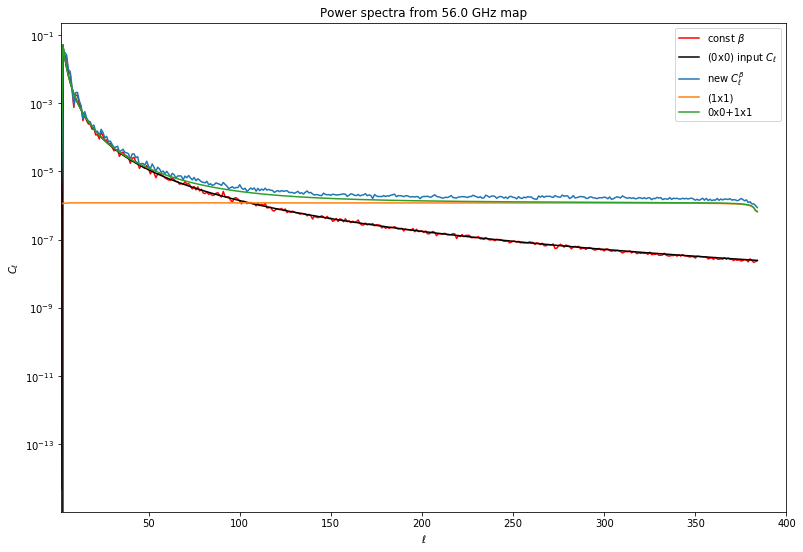

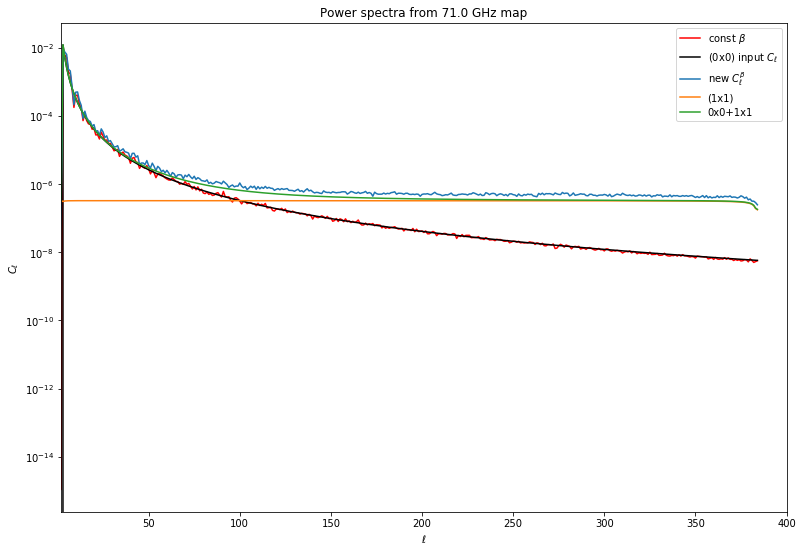

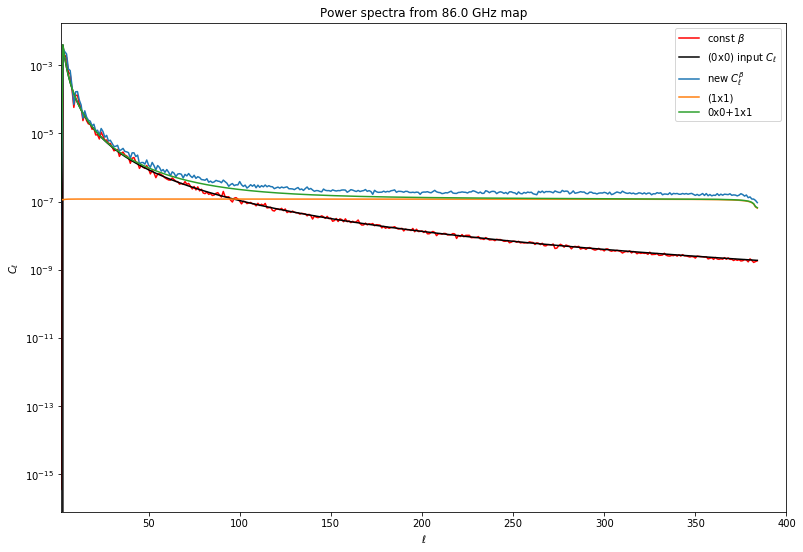

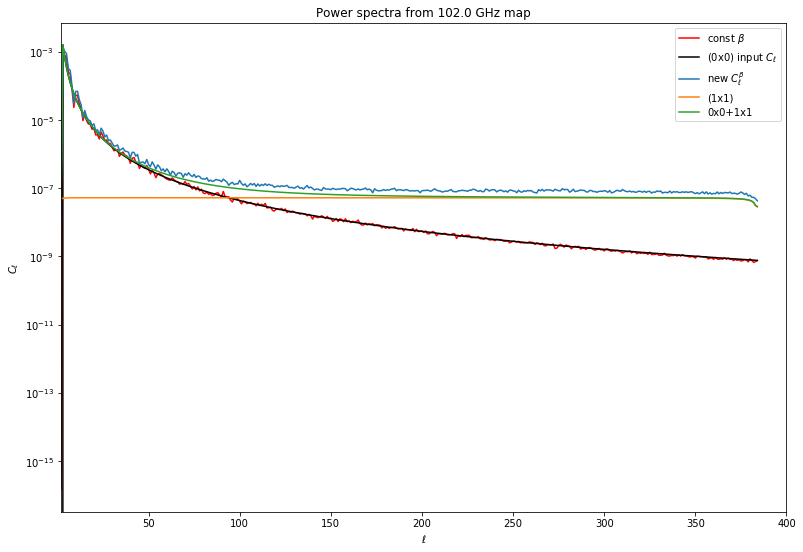

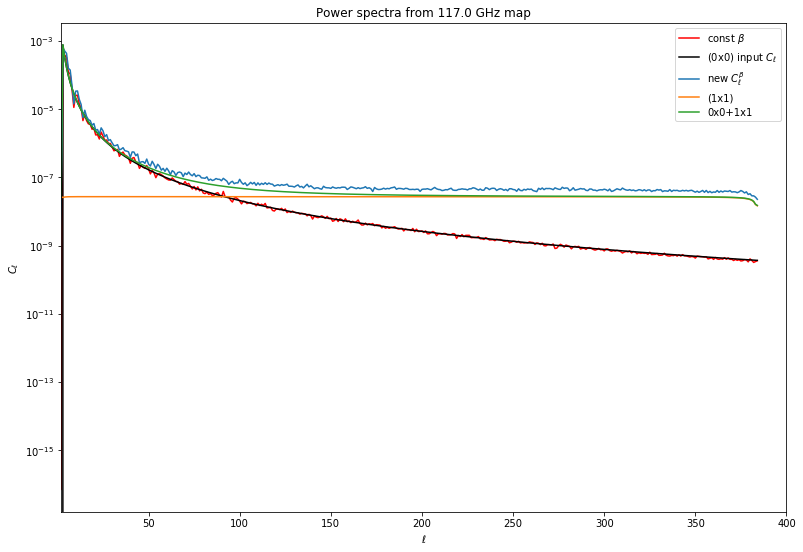

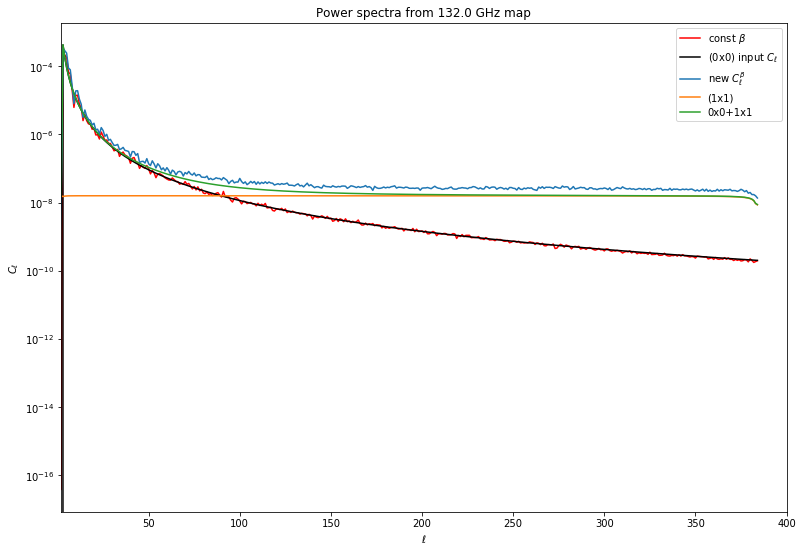

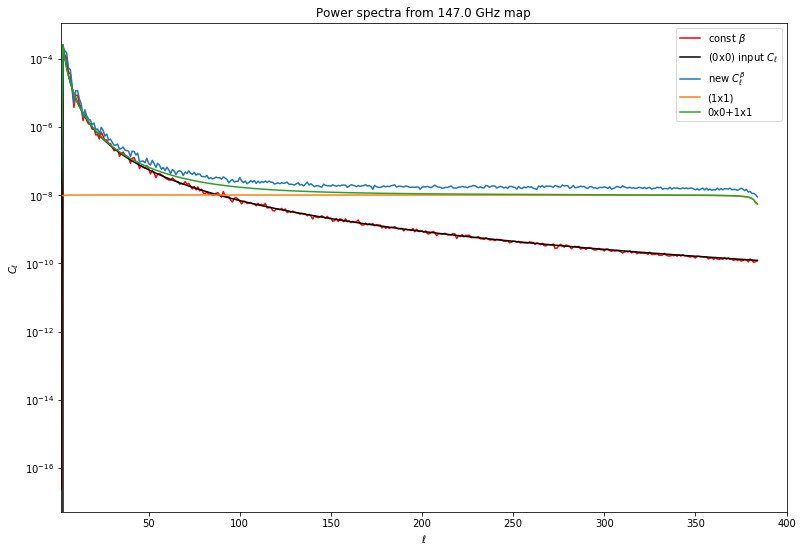

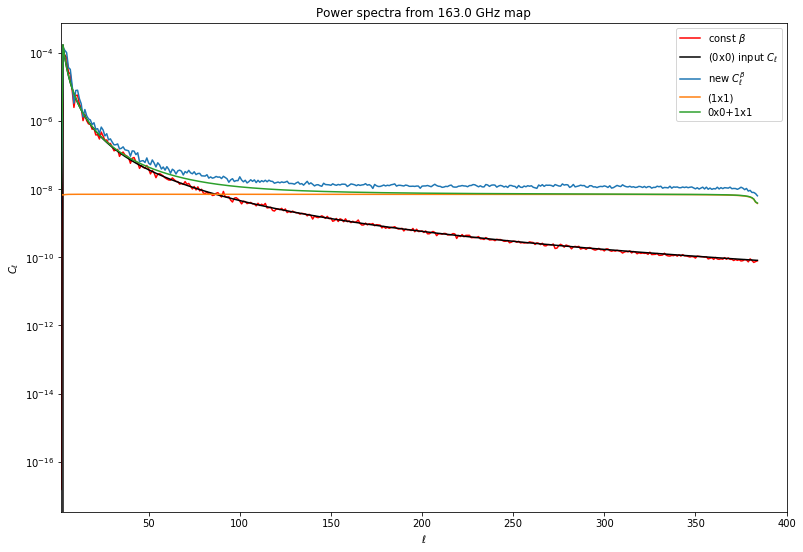

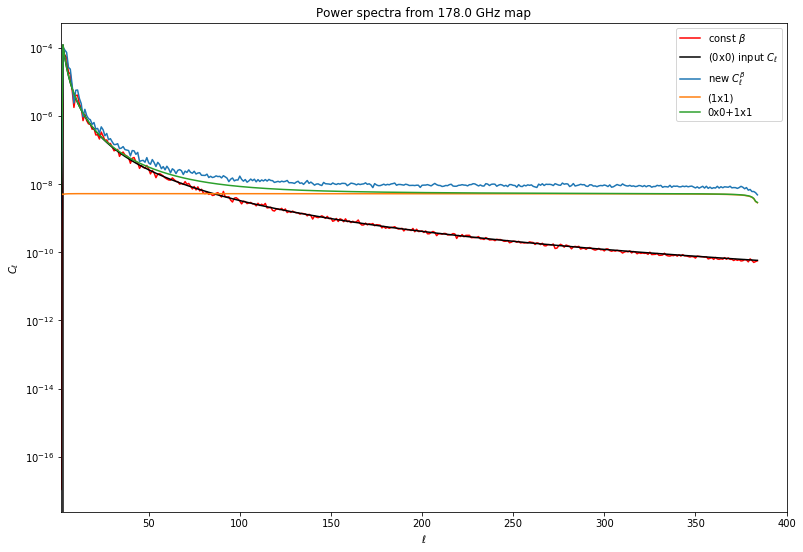

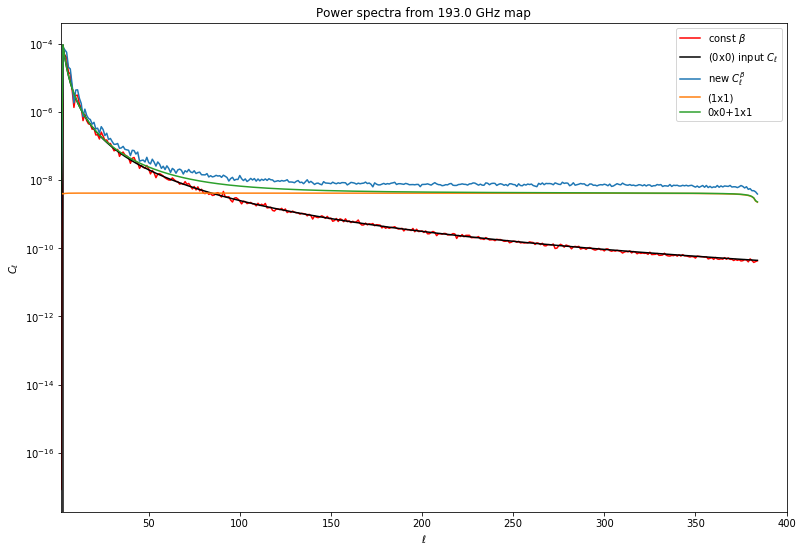

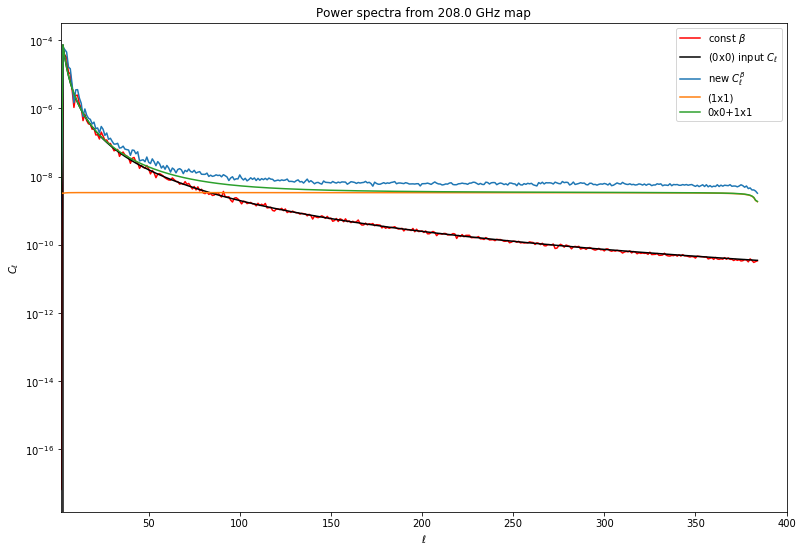

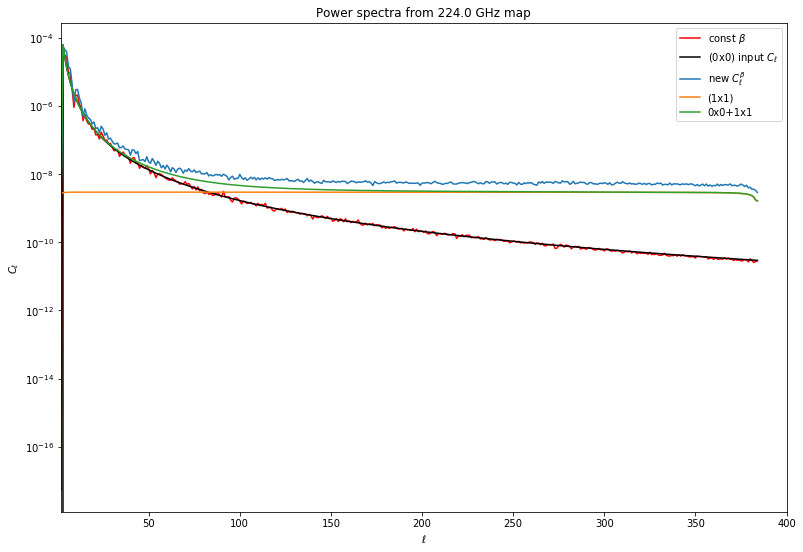

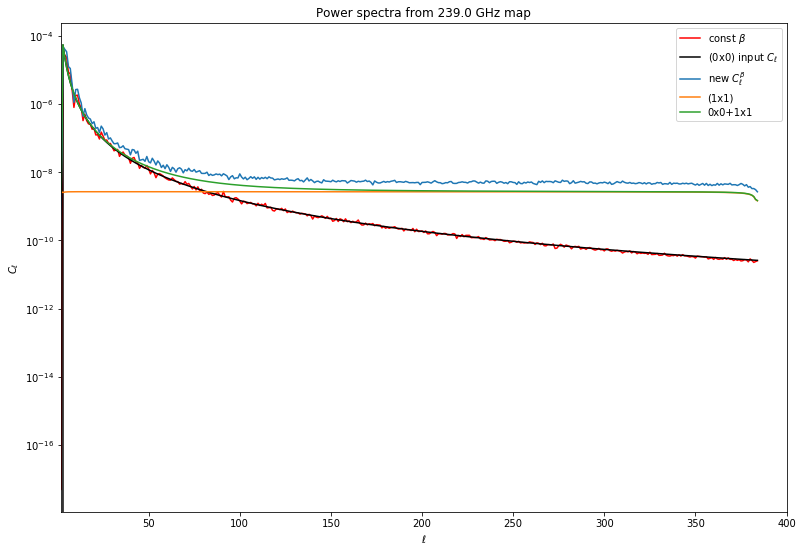

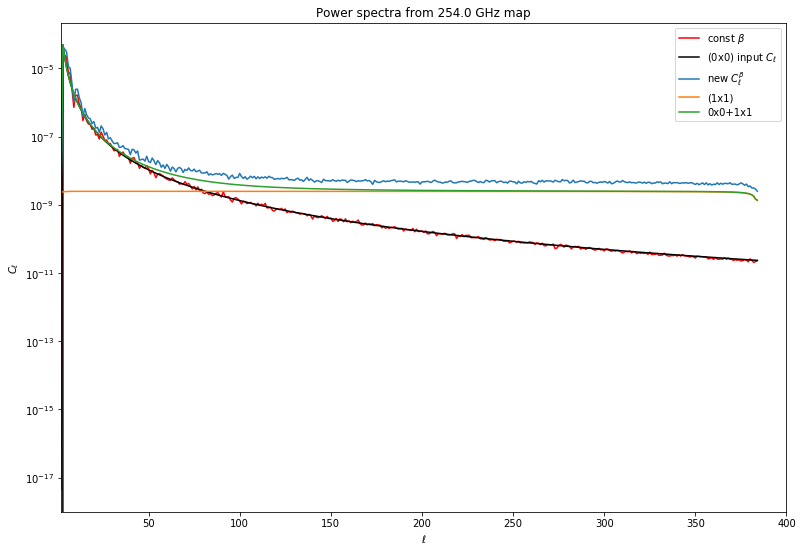

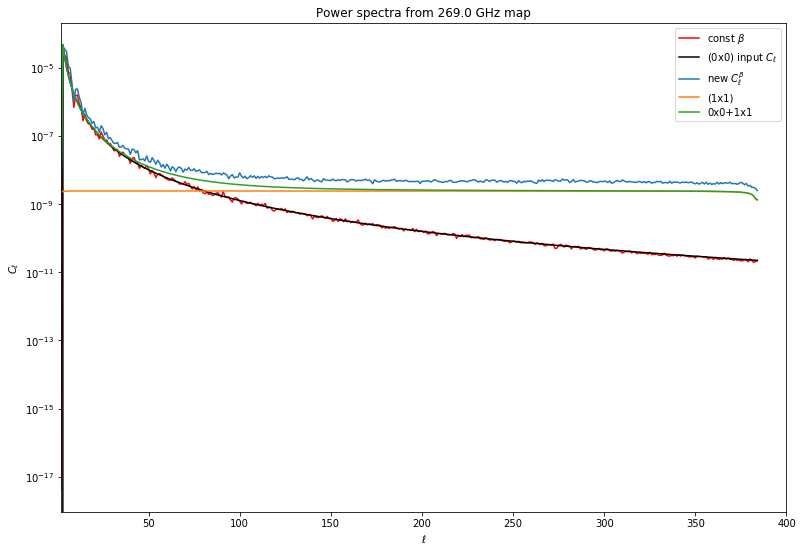

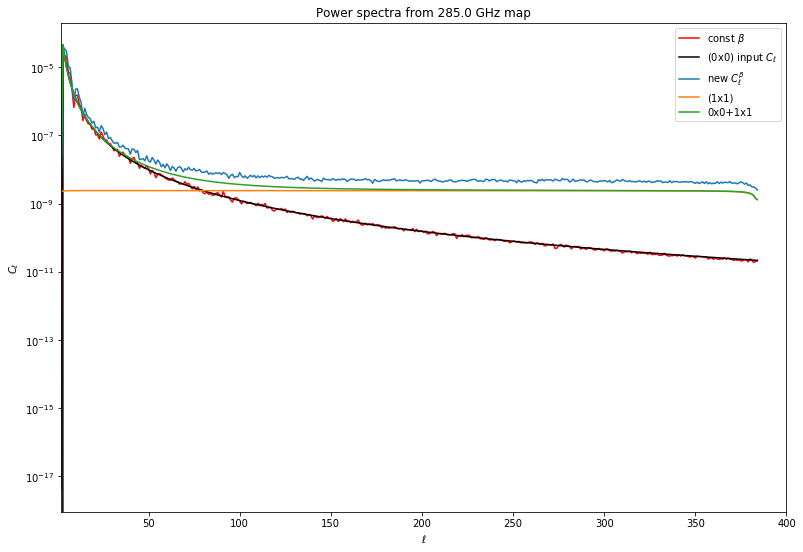

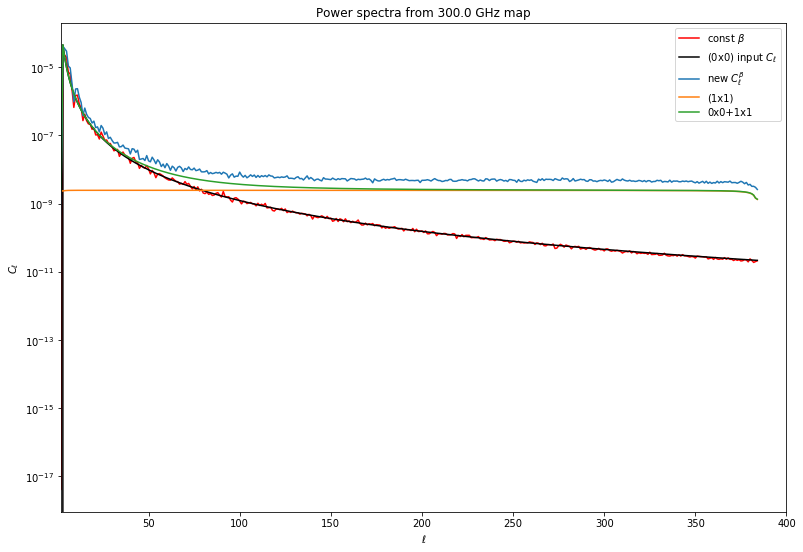

In [11]:
#plot power spectra
for k in range(20):
    #this takes the wigner sum and adds in the derivative terms out front
    moment1x1_k = log(freqs[k]/nu0)**2 * sed_scaling[k]**2 * wignersum[:Lmax] 
    theory_cls = pcls*sed_scaling[k]**2        #input c_ell
    old_cls = hp.anafast(newmaps[k])           #the input c_ell
    new_cls = hp.anafast(newmaps_beta[k])      #the c_ell from constant c_ell from the beta

    figure(figsize=(13,9))
    semilogy(ells, old_cls, 'r', label=r"const $\beta$")
    semilogy(ells, theory_cls, 'k', label=r"(0x0) input $C_\ell $")
    semilogy(ells, new_cls, label=r"new $C_\ell^\beta$")
    semilogy(ells, moment1x1_k, label=r"(1x1)")
    semilogy(ells, moment1x1_k + theory_cls, label=r"0x0+1x1")
    title("Power spectra from " + str(round(1e-9*freqs[k])) + " GHz map" )
    xlabel(r'$\ell$')
    ylabel(r'$C_\ell$')
    xlim(2,400)
    legend();


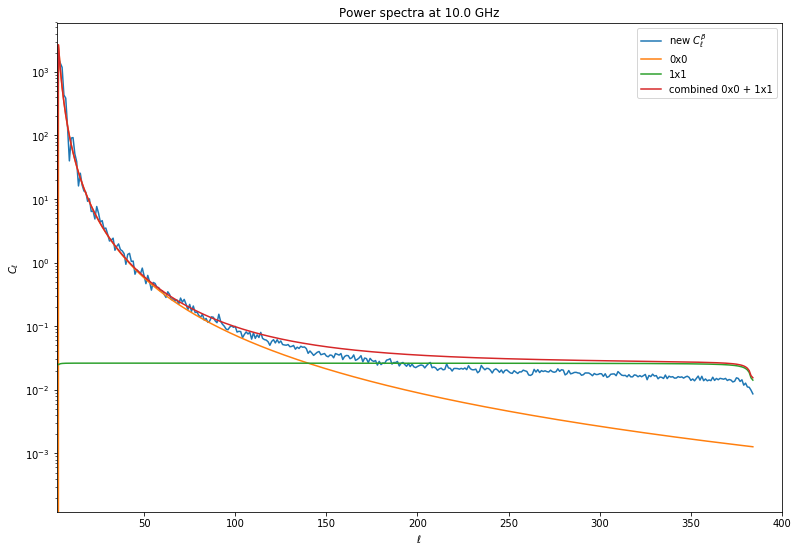

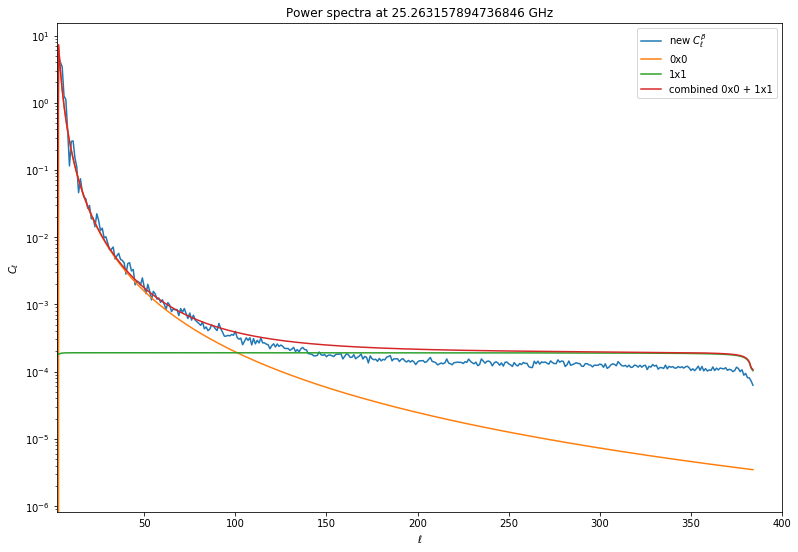

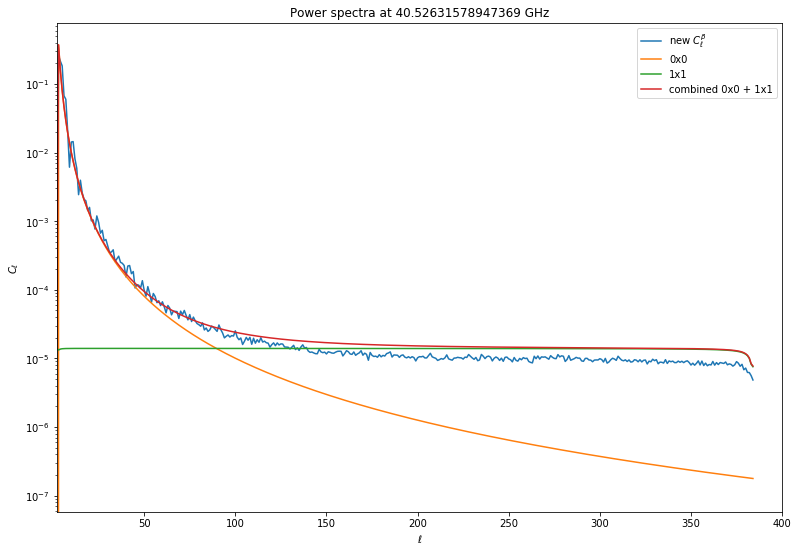

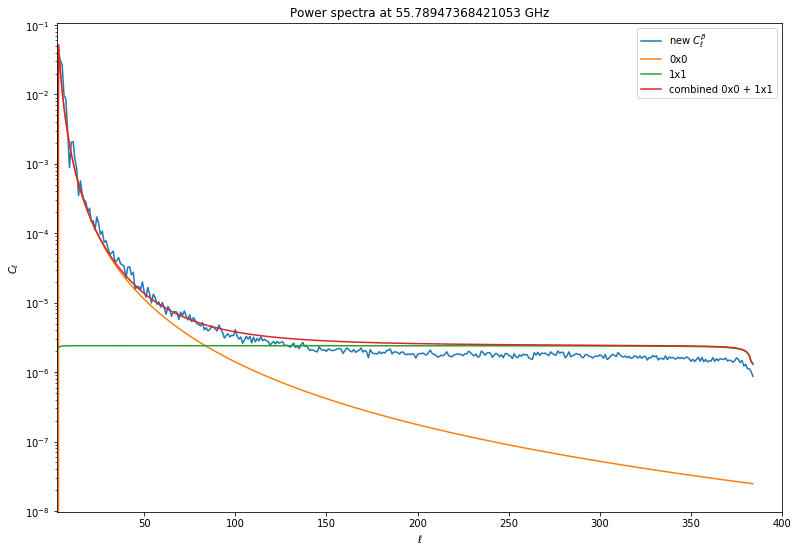

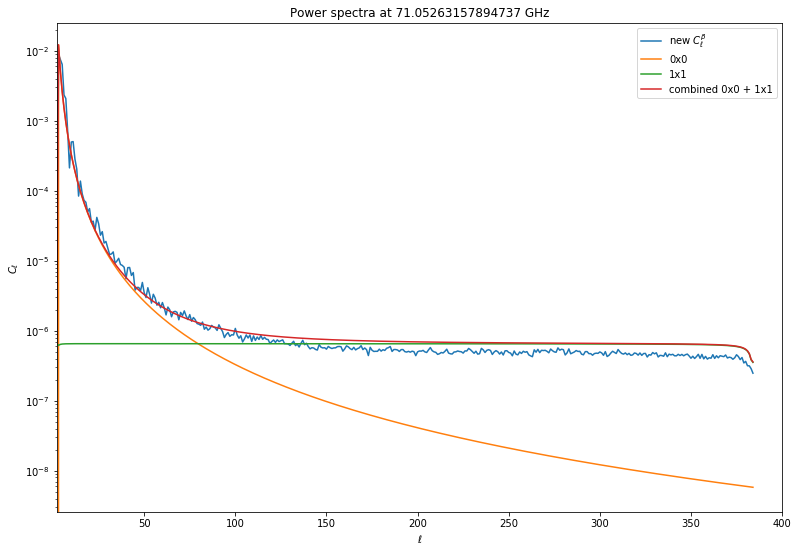

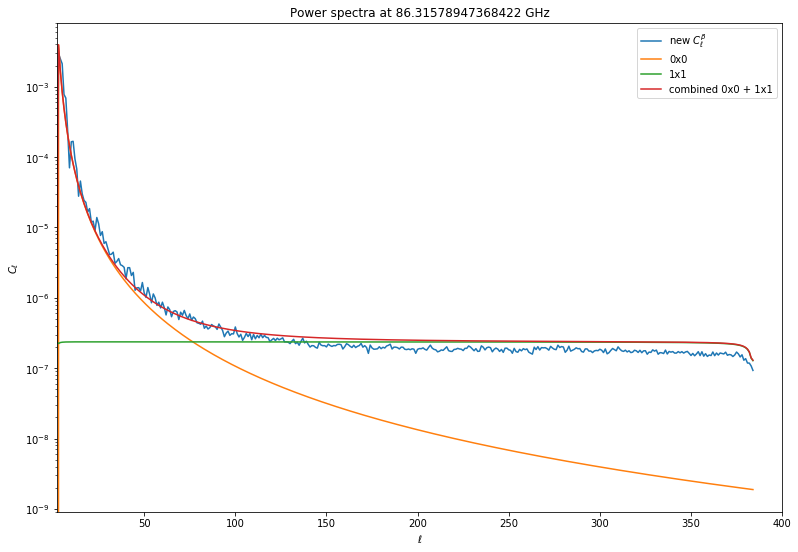

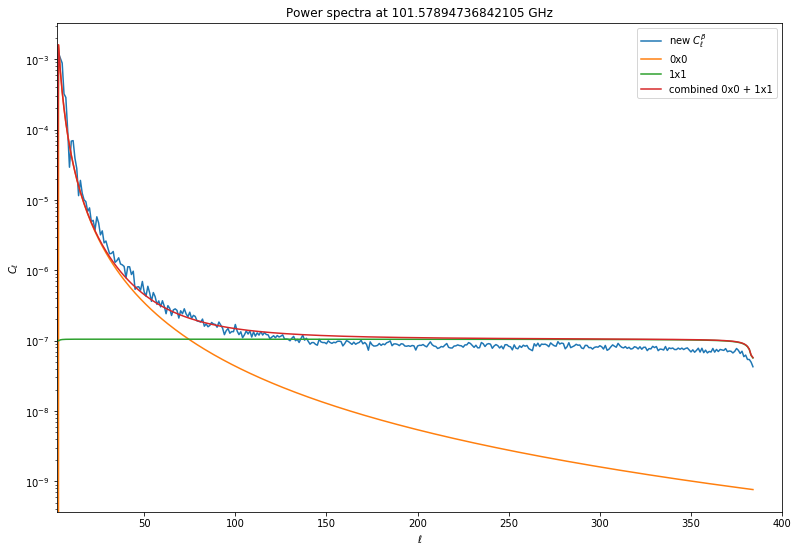

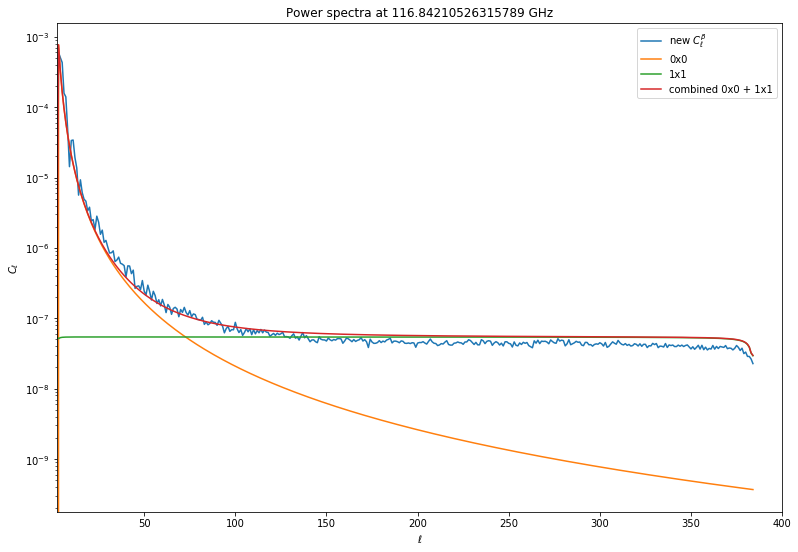

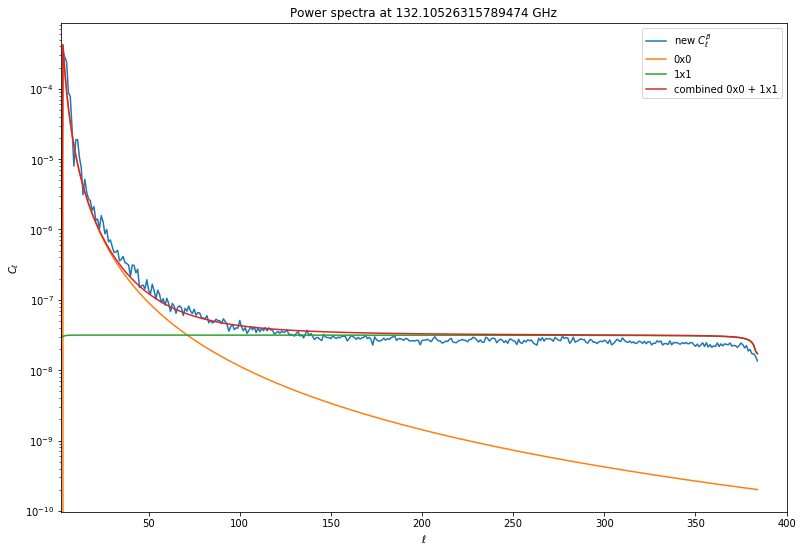

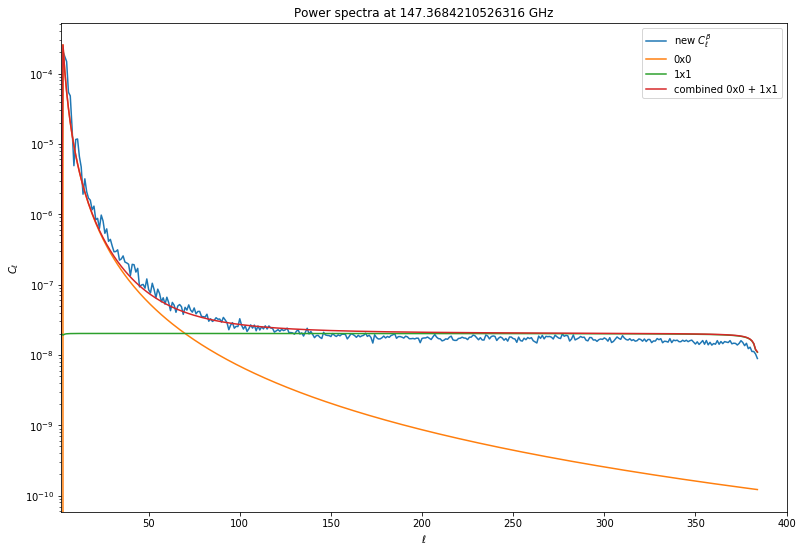

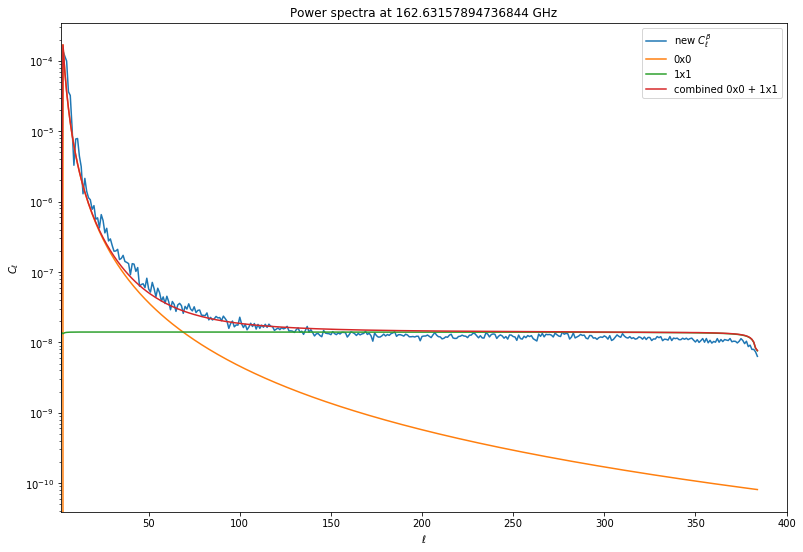

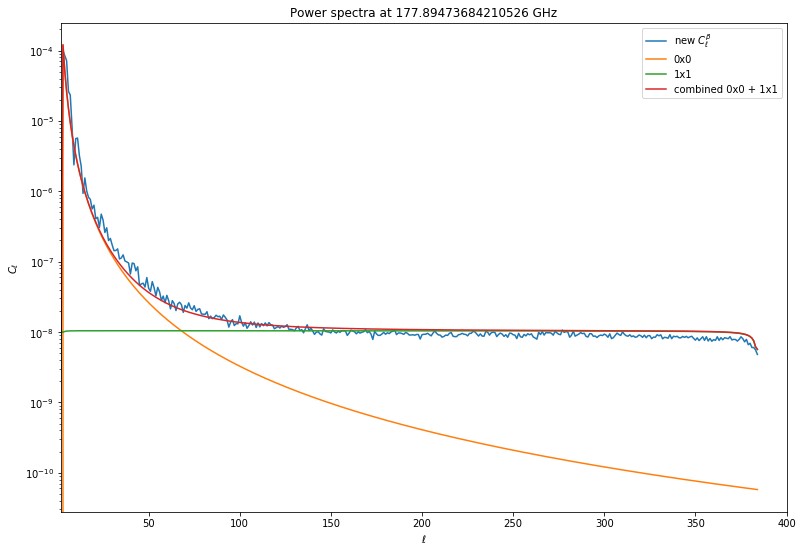

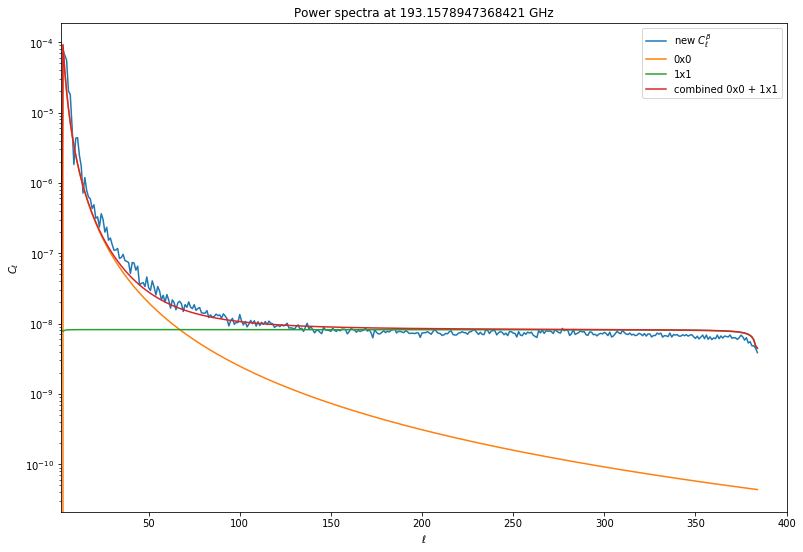

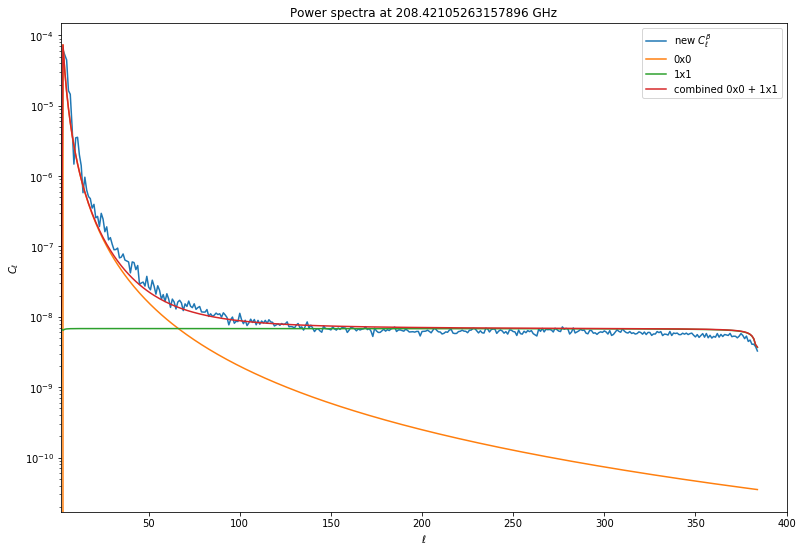

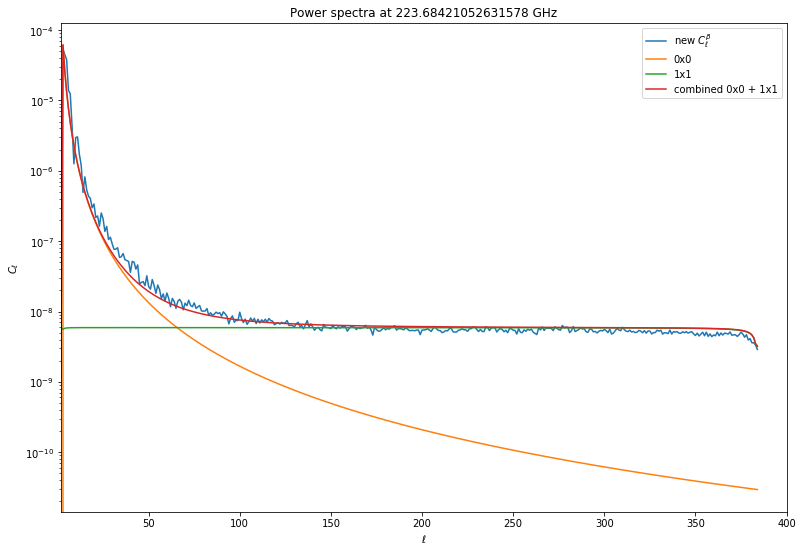

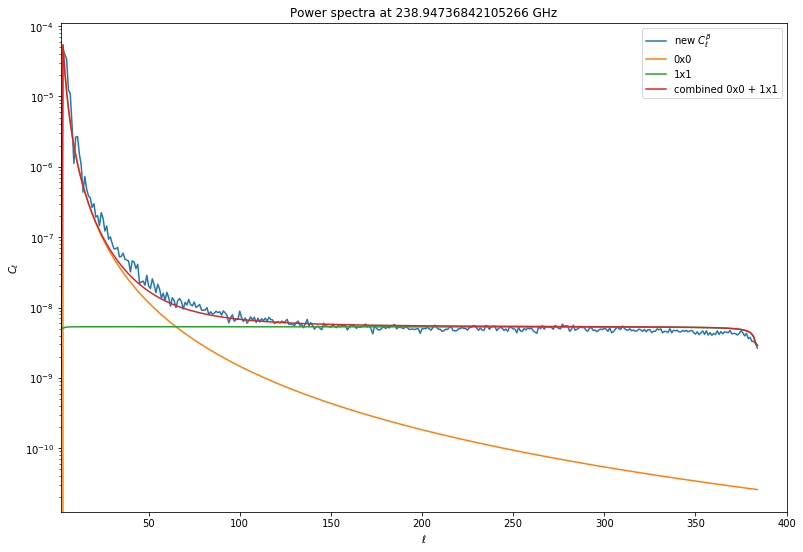

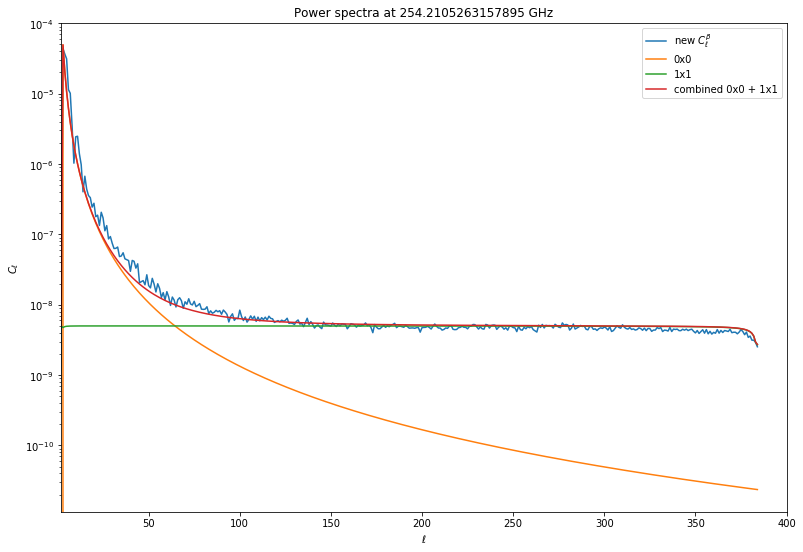

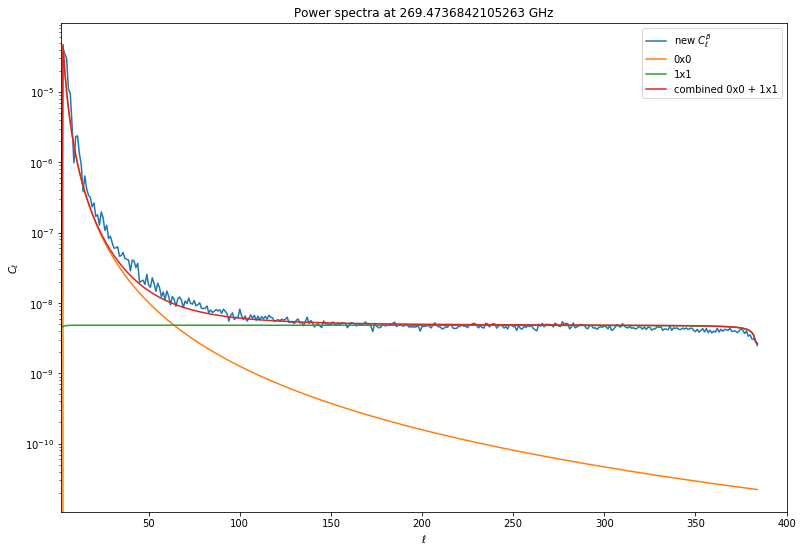

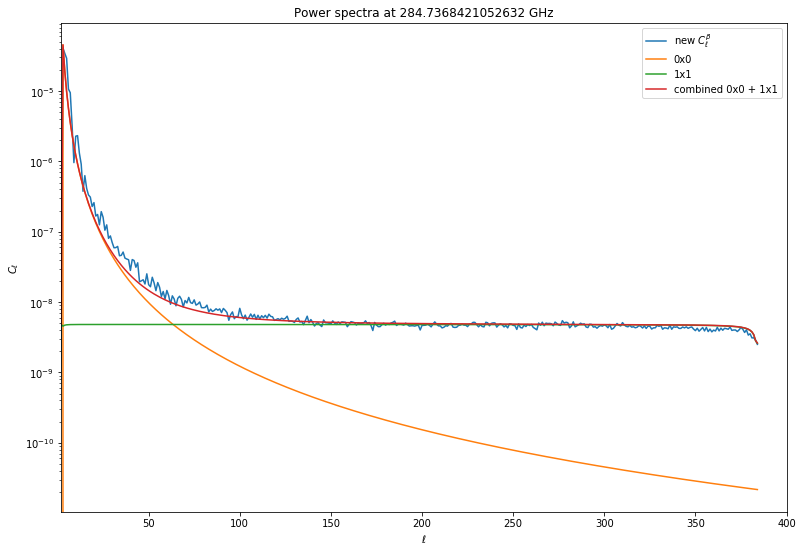

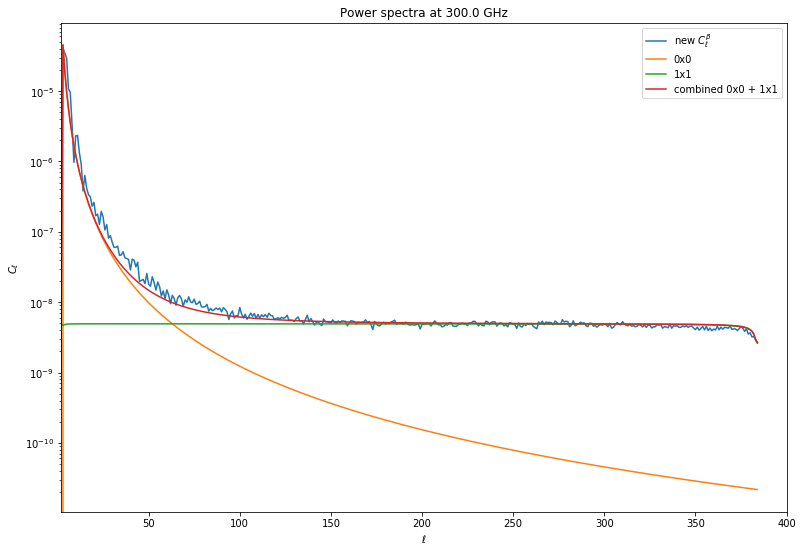

In [15]:
for k in range(20):
    moment1x1_k = log(freqs[k]/nu0)**2 * sed_scaling[k]**2 * wignersum[:Lmax] 
    moment0x0_k = pcls*sed_scaling[k]**2        #input c_ell
    new_cls = hp.anafast(newmaps_beta[k])      #the c_ell from constant c_ell from the beta
    
    figure(figsize=(13,9))
    semilogy(ells, new_cls, label=r"new $C_\ell^\beta$")
    semilogy(ells, moment0x0_k, label='0x0')
    semilogy(ells, moment1x1_k, label='1x1')
    semilogy(ells, moment0x0_k+moment1x1_k, label='combined 0x0 + 1x1')
    title('Power spectra at ' + str(freqs[k]*1e-9) + " GHz")
    xlabel(r'$\ell$')
    ylabel(r'$C_\ell$')
    xlim(2,400)
    legend();

# !!! YAY